In [1]:
import os
os.chdir('..')
os.chdir('..')
print("Current working directory:", os.getcwd())

Current working directory: /dmj/fizmed/kchorzela/licencjat/eeg-site-effects


In [ ]:
import pandas as pd
import numpy as np
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

RESULTS_PATH_SITE = 'results/tables/04_pca_sensitivity/pca_sensitivity_results_site.csv'
RESULTS_PATH_PATHO = 'results/tables/04_pca_sensitivity/pca_sensitivity_results_patho.csv'

RESULTS_FULL_PATH_SITE = 'results/tables/04_pca_sensitivity/pca_sensitivity_results_site_full.csv'
RESULTS_FULL_PATH_PATHO = 'results/tables/04_pca_sensitivity/pca_sensitivity_results_patho_full.csv'

METHODS = ['raw', 'sitewise', 'combat', 'neurocombat', 'covbat']

PCA_VARIANTS = [0.0, 1.0, 0.99, 0.95, 0.90, 0.80]

In [8]:
patho_results_df = pd.read_csv(RESULTS_PATH_PATHO)
patho_results_full_df = pd.read_csv(RESULTS_FULL_PATH_PATHO)

In [9]:
patho_results_df['pca_var'] = patho_results_df['pca_var'].fillna(0.0)
patho_results_full_df['pca_var'] = patho_results_full_df['pca_var'].fillna(1.0)


In [11]:
patho_results_df

,accuracy,precision,recall,f1-score,auc,mcc,hospital,method,n_calib,n_test,pca_var,n_features
0,0.818325,0.923780,0.854323,0.887695,0.857282,0.425113,AKS,raw,30,1266,0.0,2850
1,0.784851,0.589396,0.594527,0.591950,0.807335,0.445875,ARCHDAM,raw,30,3063,0.0,2850
2,0.700253,0.423493,0.729694,0.535941,0.791115,0.364104,B2K,raw,30,3166,0.0,2850
3,0.495482,0.969072,0.463816,0.627364,0.744420,0.169759,CHE,raw,30,664,0.0,2850
4,0.802817,0.776699,0.567376,0.655738,0.866990,0.534873,CMD,raw,30,426,0.0,2850
...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.612121,0.450839,0.548105,0.494737,0.631869,0.187121,TER_L,covbat,30,990,1.0,2850
146,0.678495,0.407332,0.961538,0.572246,0.892300,0.466169,TOR,covbat,30,930,1.0,2850
147,0.628096,0.900956,0.569762,0.698068,0.748041,0.324991,WLU,covbat,30,3068,1.0,2850
148,0.672469,0.804614,0.599678,0.687192,0.762136,0.375718,Z04O,covbat,30,3102,1.0,2850


In [12]:
patho_results_df = pd.concat([patho_results_df, patho_results_full_df], axis=0)

In [13]:
color_grid = [
    'black', 'tomato', 'skyblue', 'green',
    'orange', 'purple', 'brown', 'cyan',
    'magenta', 'yellow', 'pink', 'lime'
]

In [15]:
patho_results_df

,accuracy,precision,recall,f1-score,auc,mcc,hospital,method,n_calib,n_test,pca_var,n_features
0,0.818325,0.923780,0.854323,0.887695,0.857282,0.425113,AKS,raw,30,1266,0.0,2850
1,0.784851,0.589396,0.594527,0.591950,0.807335,0.445875,ARCHDAM,raw,30,3063,0.0,2850
2,0.700253,0.423493,0.729694,0.535941,0.791115,0.364104,B2K,raw,30,3166,0.0,2850
3,0.495482,0.969072,0.463816,0.627364,0.744420,0.169759,CHE,raw,30,664,0.0,2850
4,0.802817,0.776699,0.567376,0.655738,0.866990,0.534873,CMD,raw,30,426,0.0,2850
...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.612121,0.450839,0.548105,0.494737,0.631869,0.187121,TER_L,covbat,30,990,1.0,2850
146,0.678495,0.407332,0.961538,0.572246,0.892300,0.466169,TOR,covbat,30,930,1.0,2850
147,0.628096,0.900956,0.569762,0.698068,0.748041,0.324991,WLU,covbat,30,3068,1.0,2850
148,0.672469,0.804614,0.599678,0.687192,0.762136,0.375718,Z04O,covbat,30,3102,1.0,2850


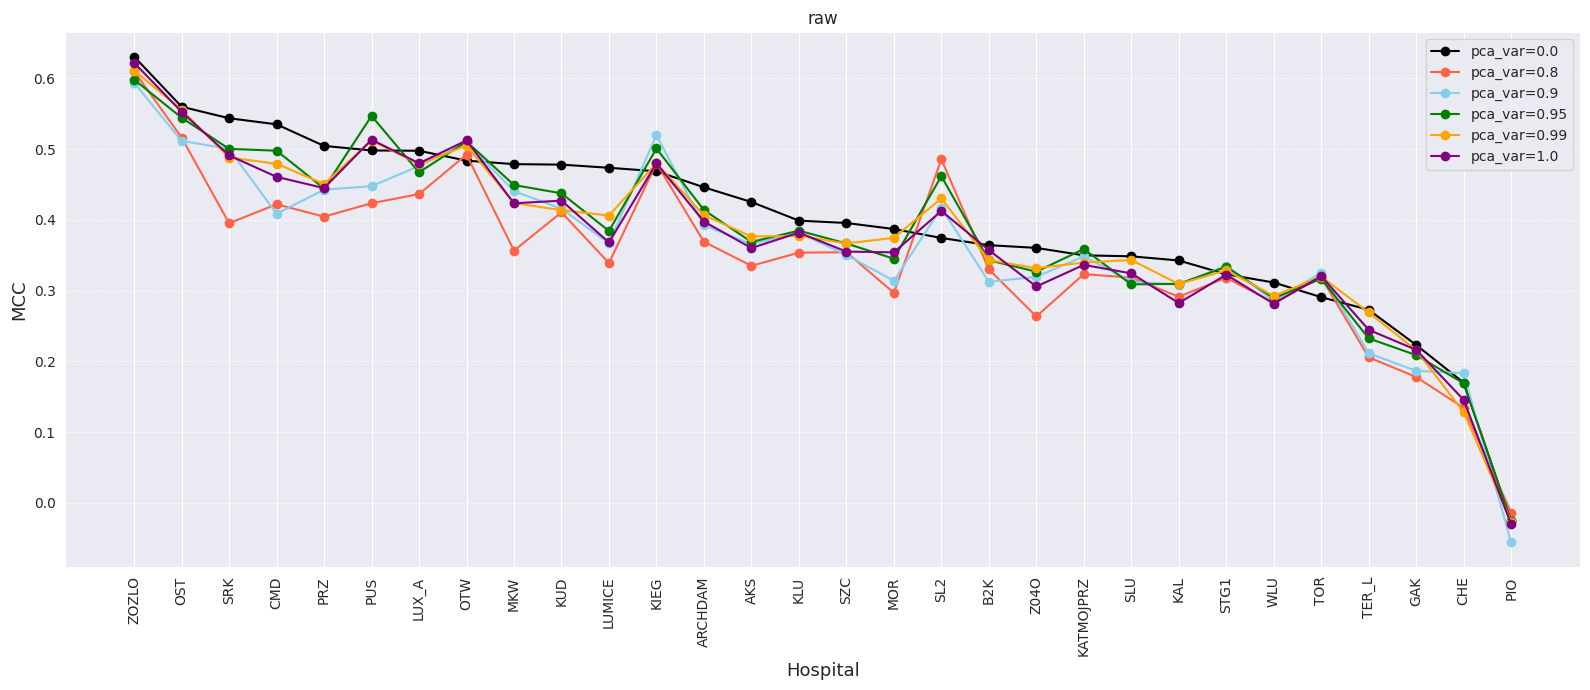

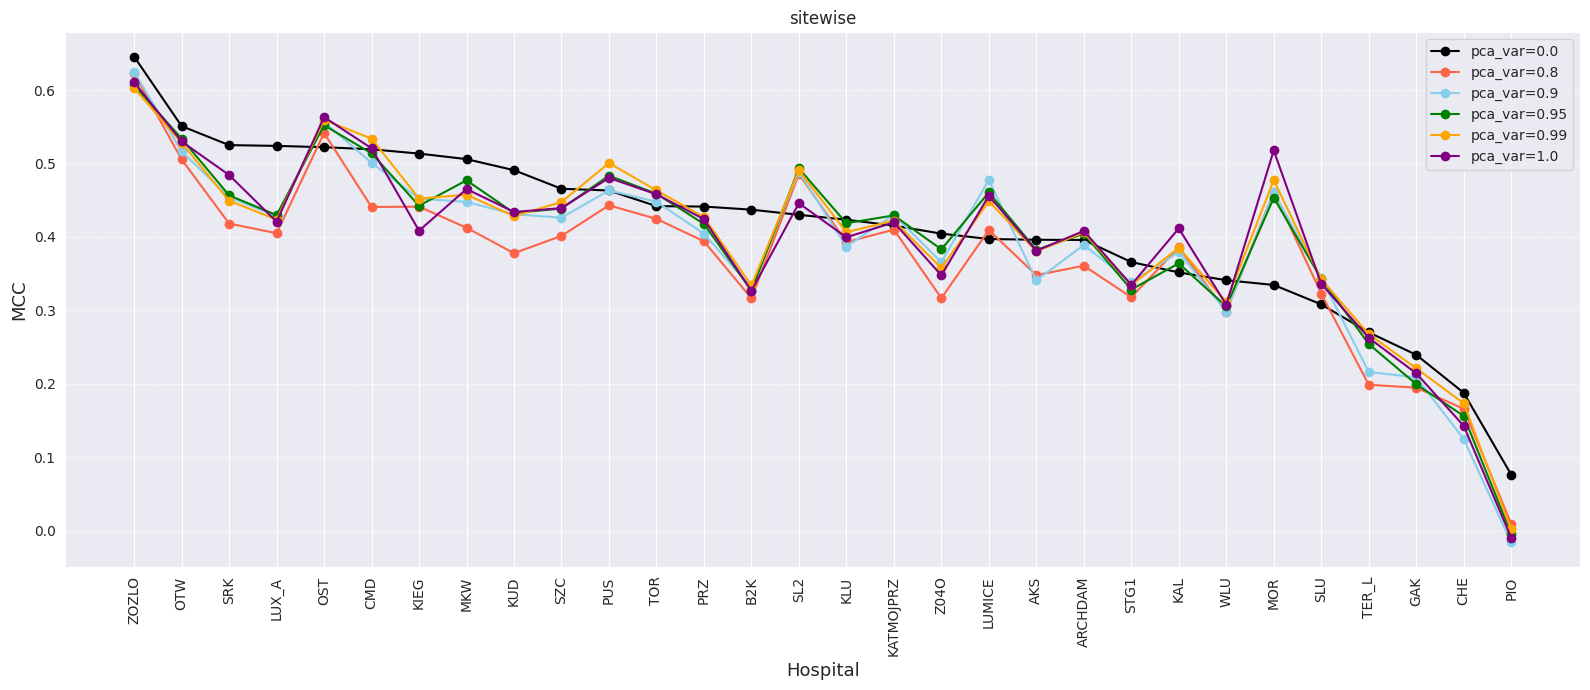

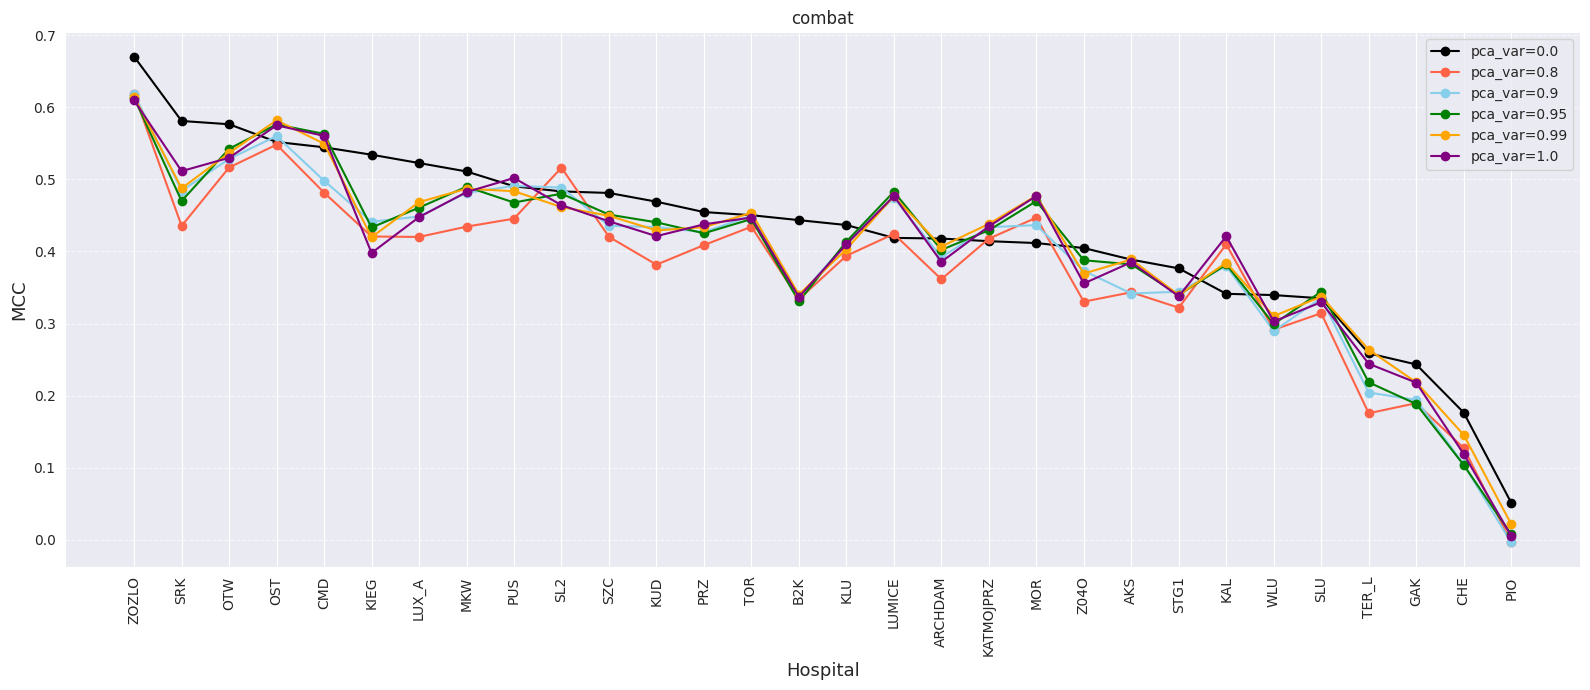

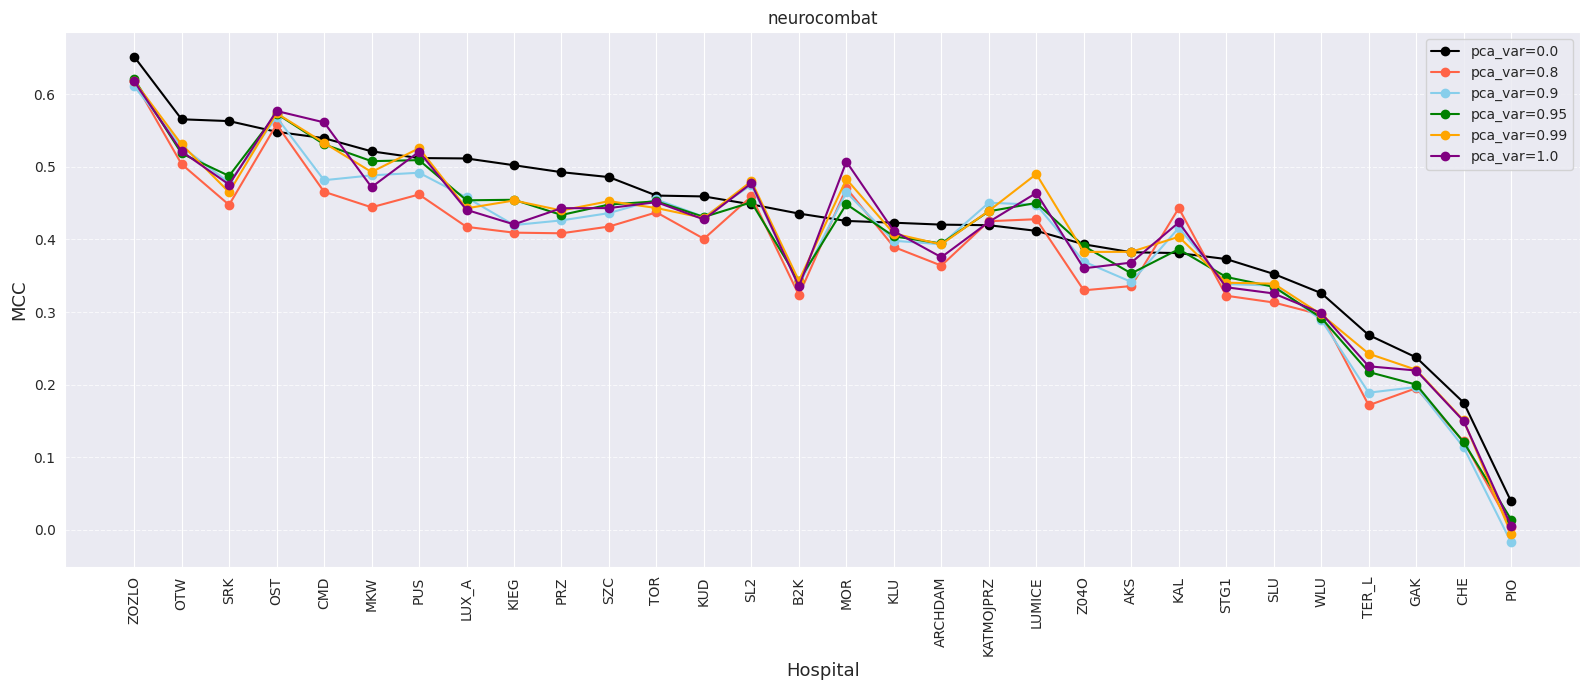

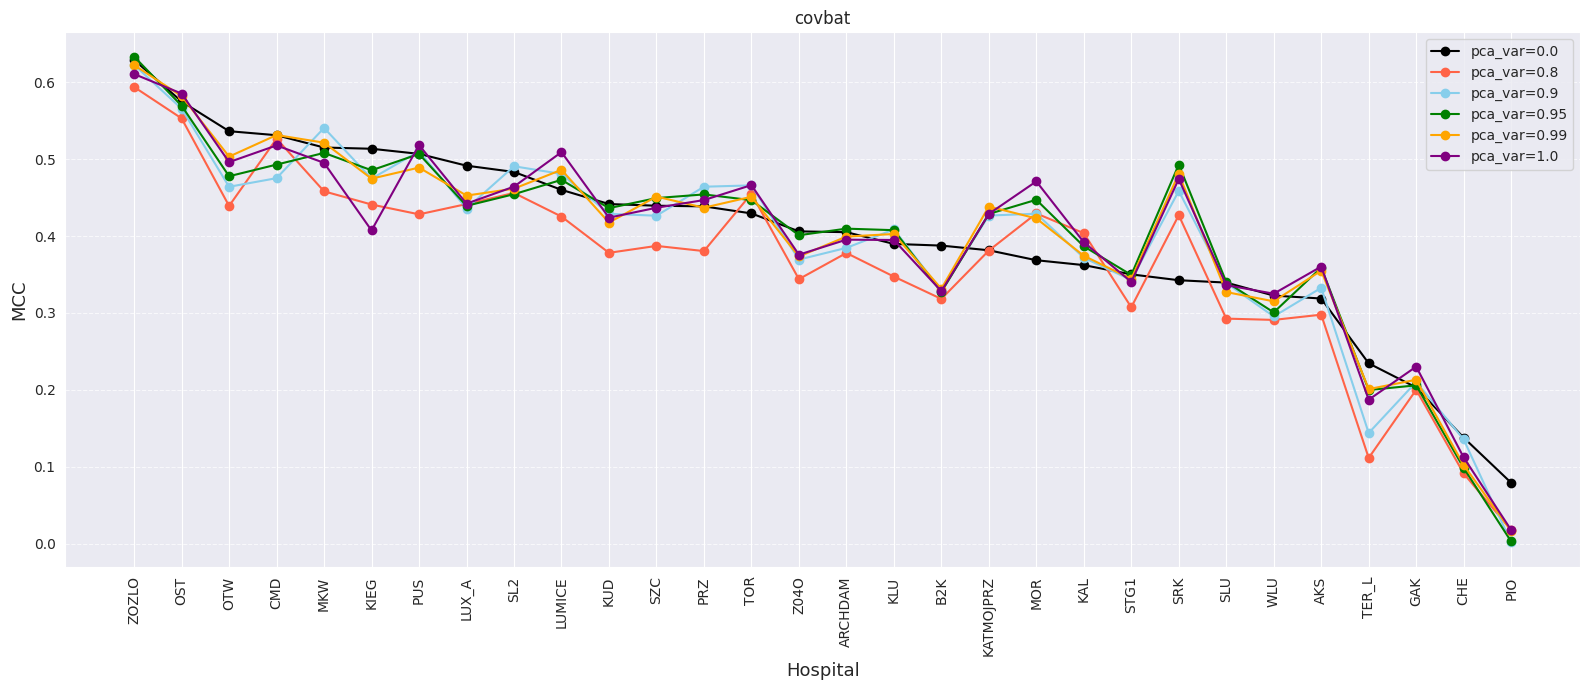

In [20]:
metric = 'mcc'
for method in METHODS:
    plt.figure(figsize=(16, 7))

    pivot_df = patho_results_df[patho_results_df['method'] == method].pivot_table(
        index='pca_var',
        columns='hospital',
        values=metric
    )

    reference_series = pivot_df.iloc[0]
    sort_idx = reference_series.values.argsort()[::-1]
    hospitals_sorted = reference_series.index.values[sort_idx]

    for pca_idx, pca in enumerate(pivot_df.index):
        row = pivot_df.loc[pca]
        values = [row.get(h, np.nan) for h in hospitals_sorted]

        plt.plot(
            hospitals_sorted,
            values,
            marker='o',
            linestyle='-',
            color=color_grid[pca_idx % len(color_grid)],
            label=f"pca_var={pca}"
        )

    plt.ylabel(metric.upper(), fontsize=13)
    plt.xlabel("Hospital", fontsize=13)
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title(f"{method}")
    plt.legend()
    plt.tight_layout()
    plt.show()


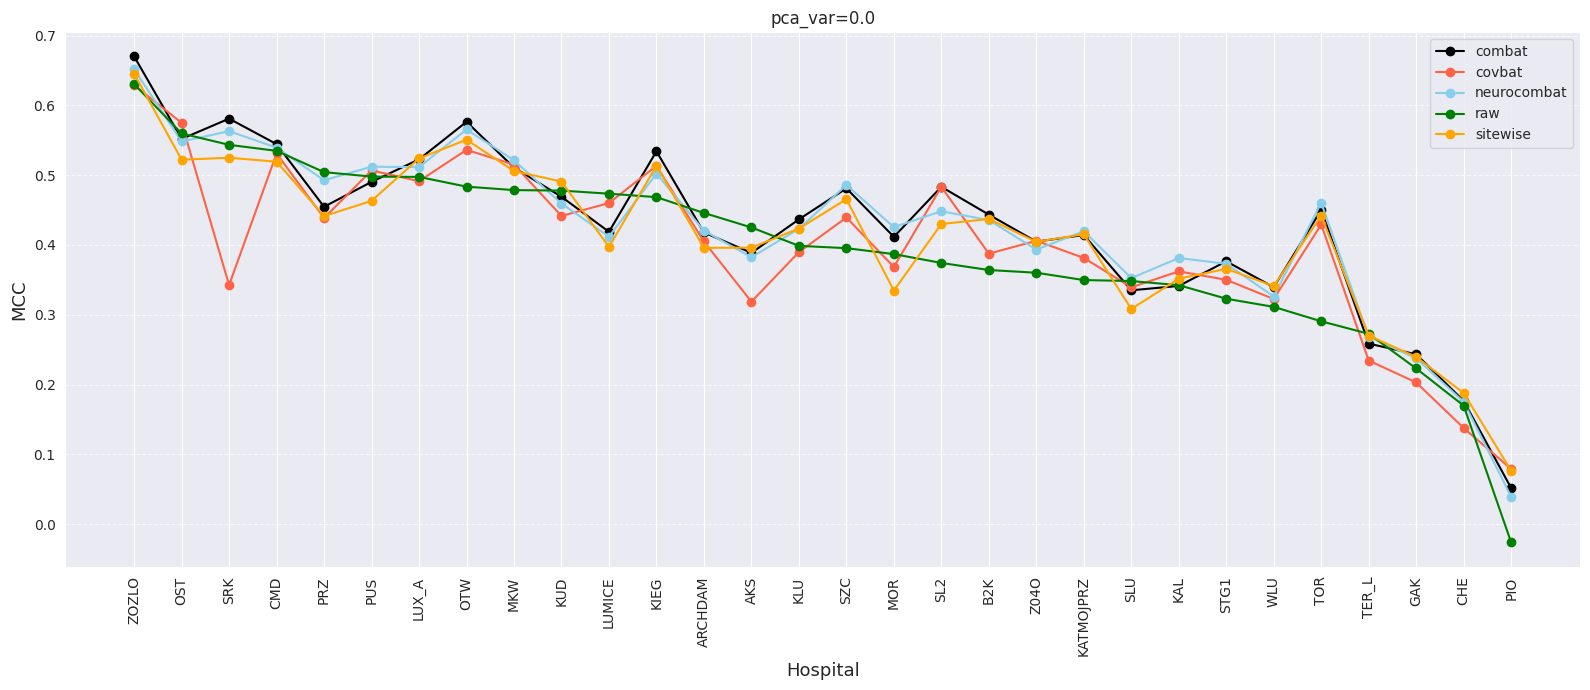

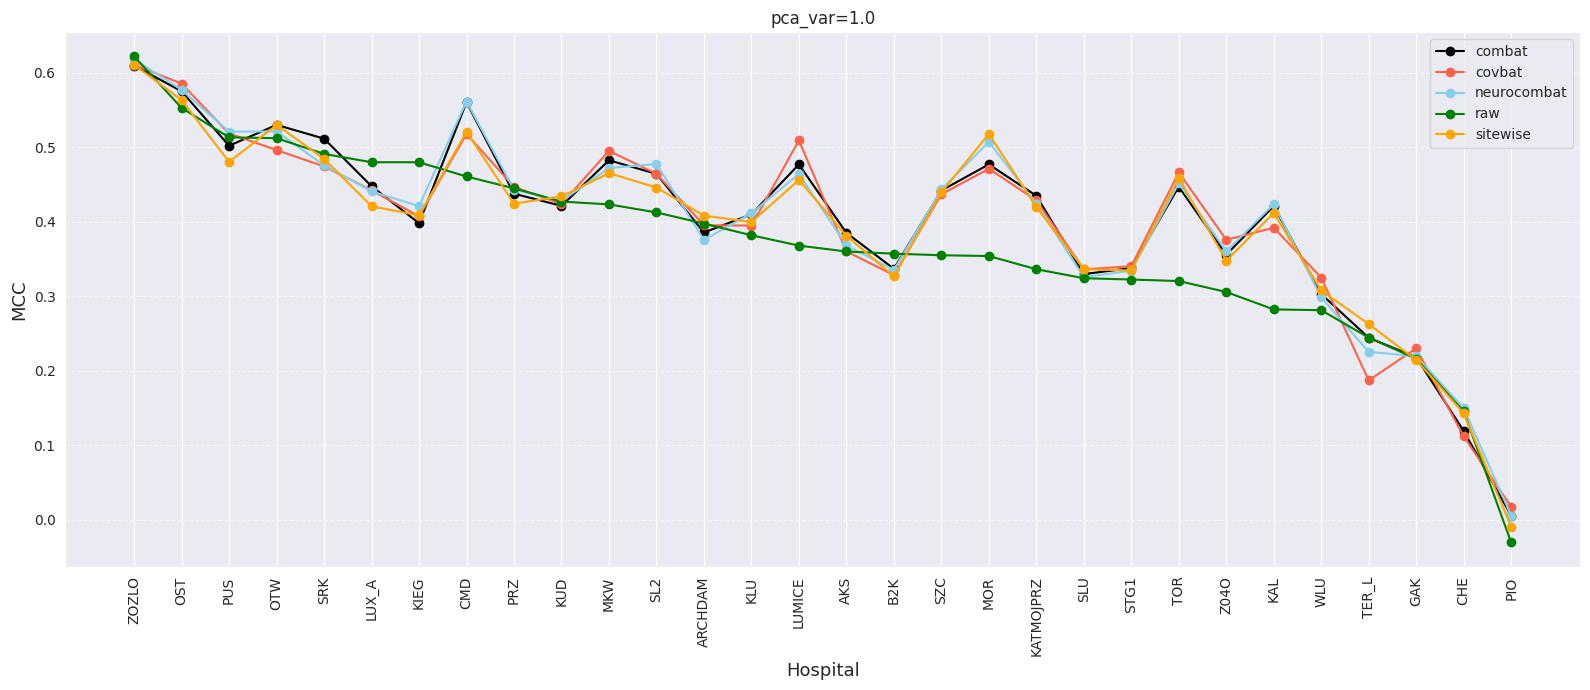

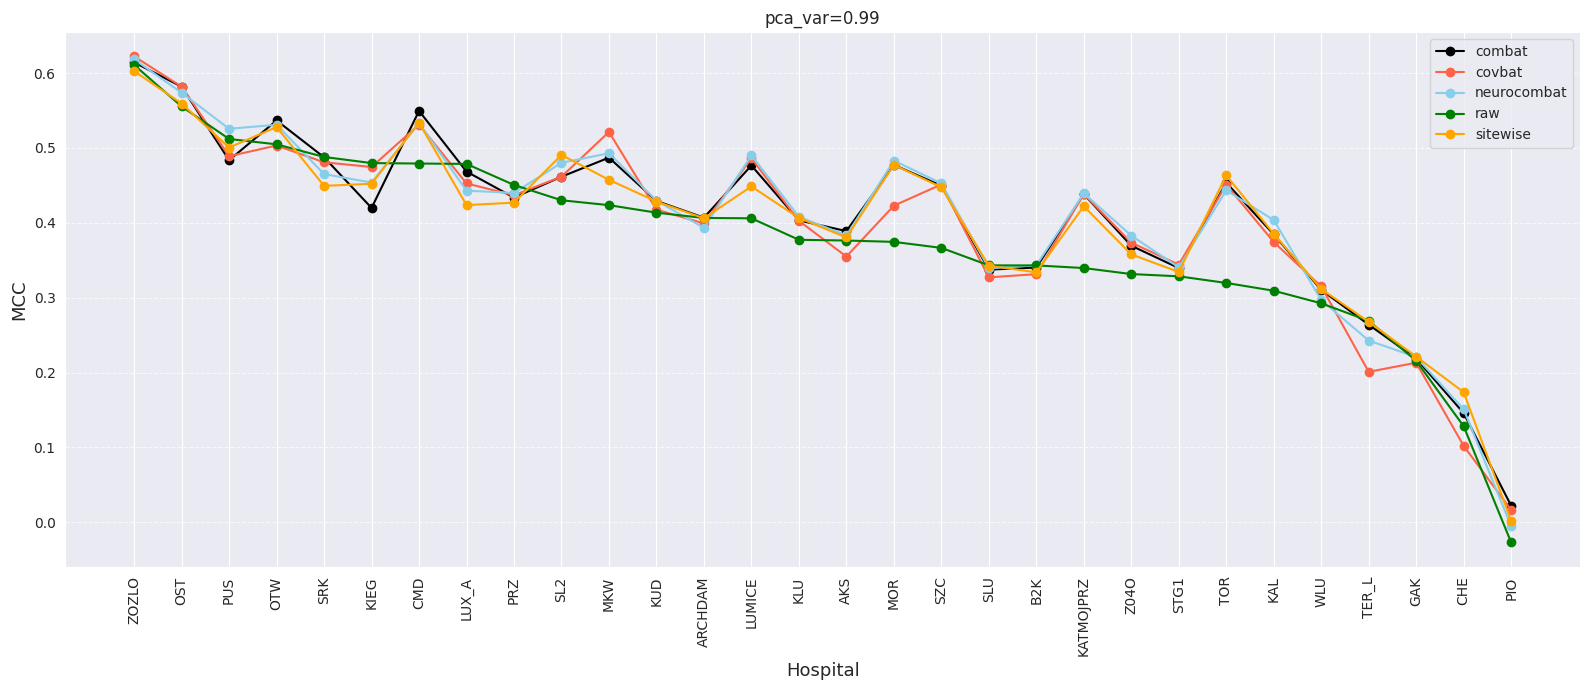

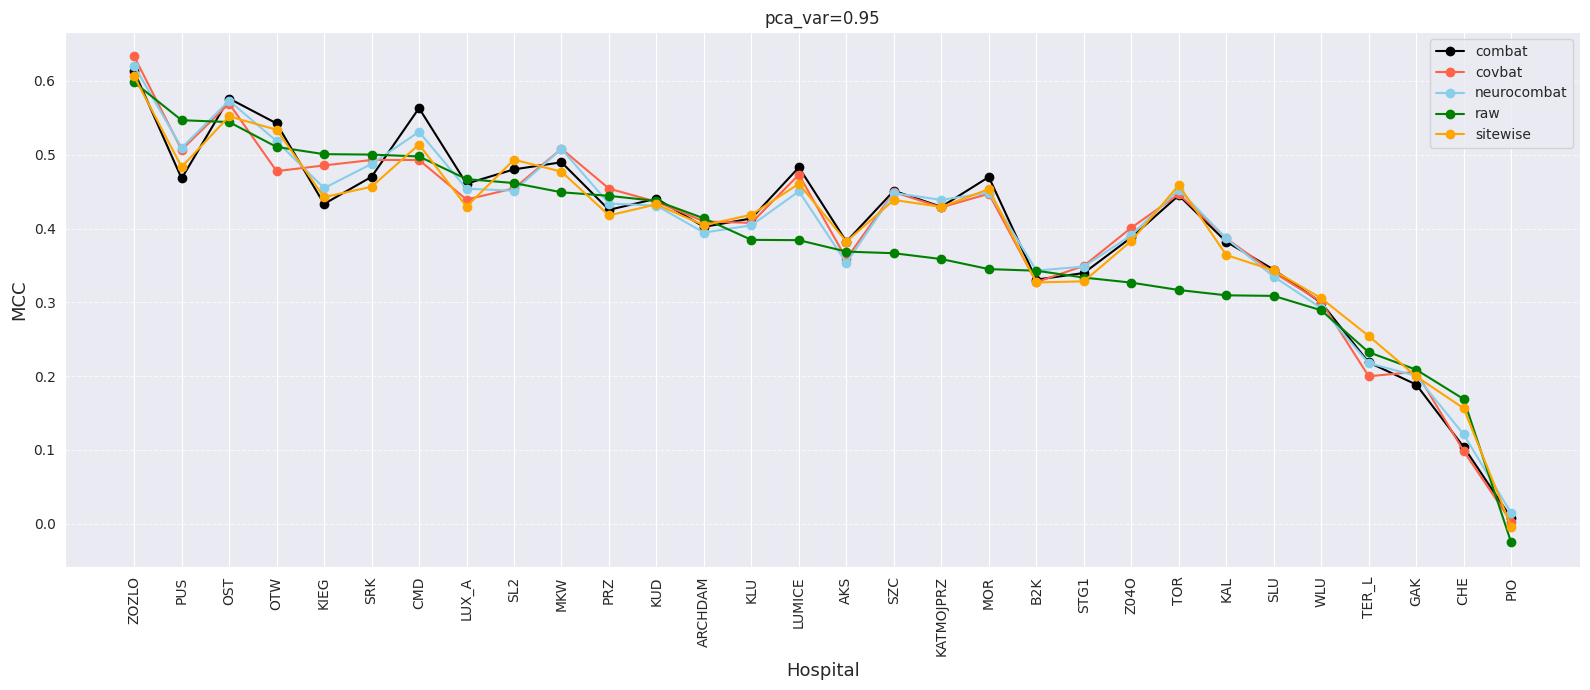

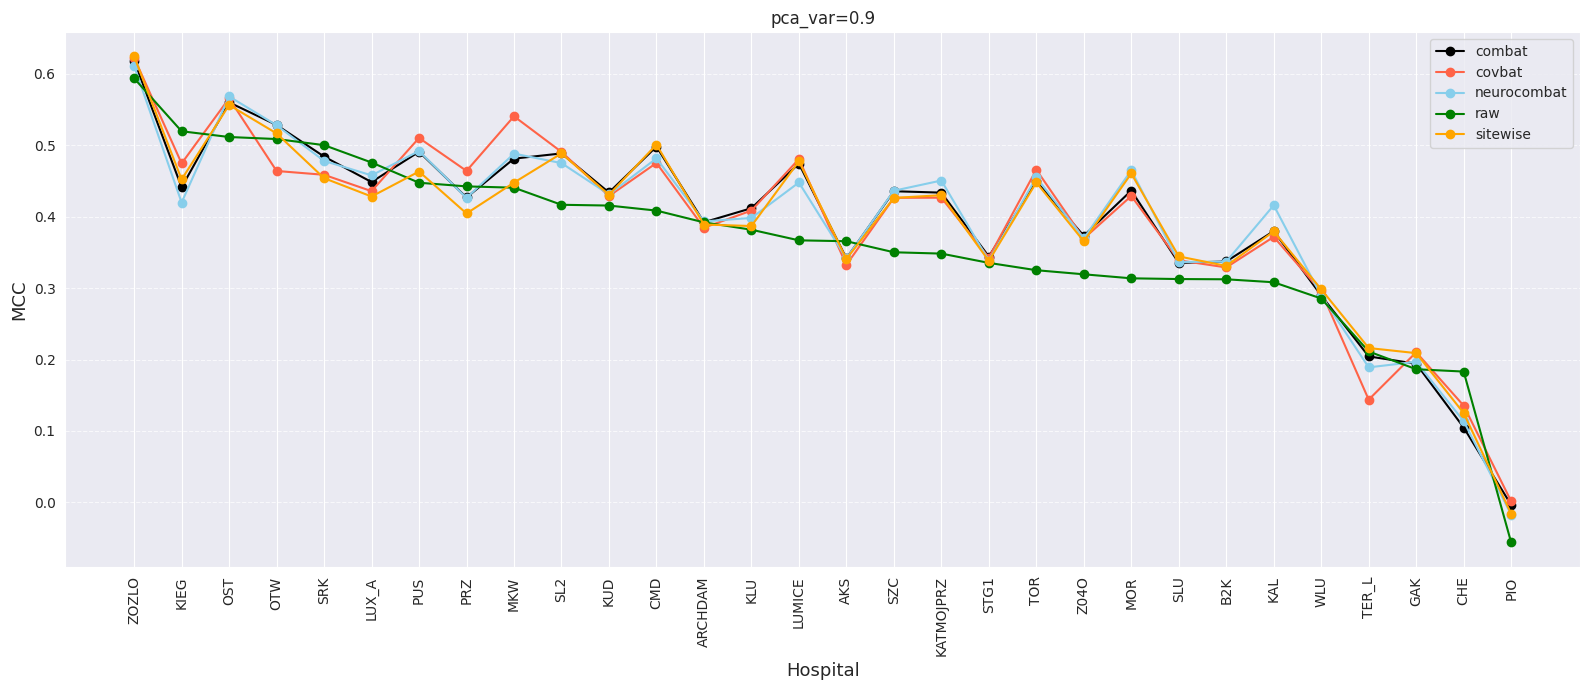

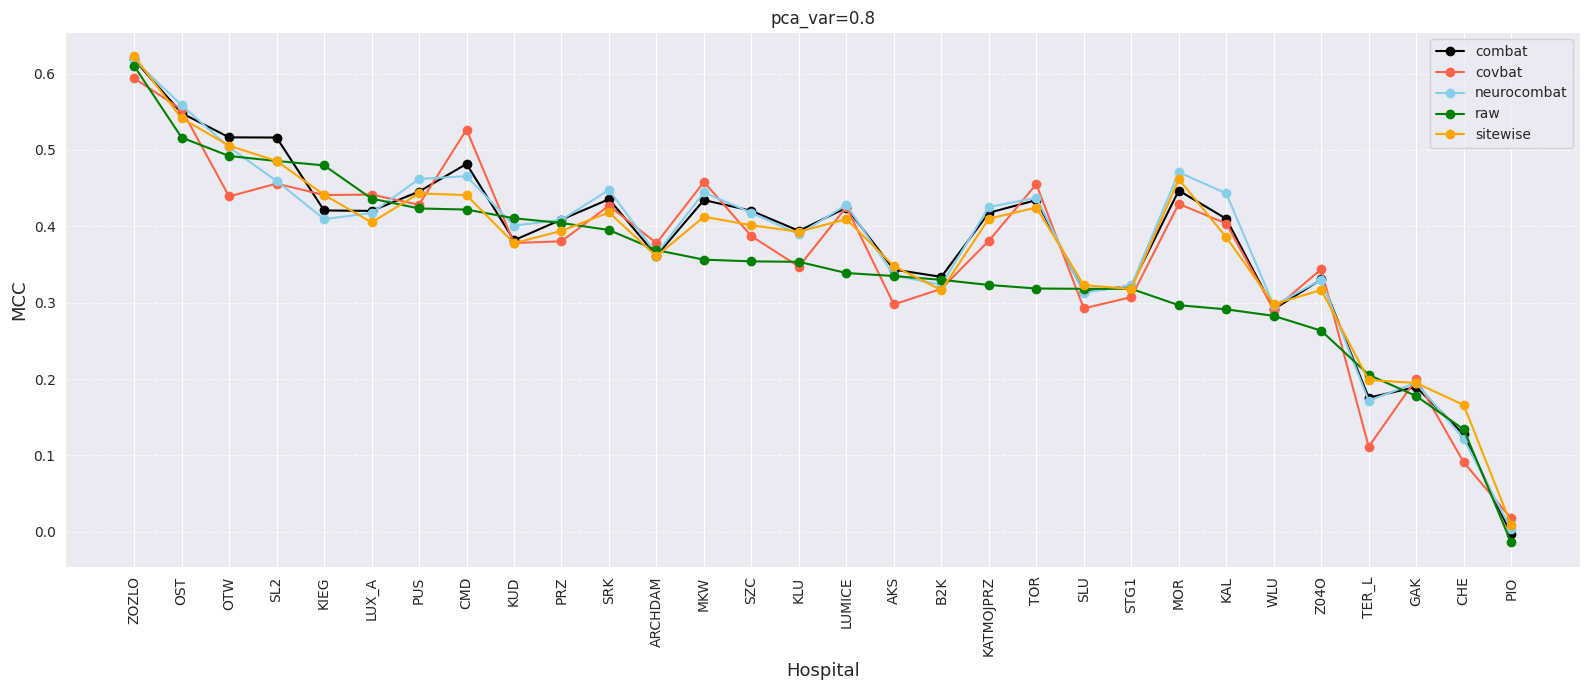

In [19]:
metric = 'mcc'
for pca in PCA_VARIANTS:

    plt.figure(figsize=(16, 7))

    pivot_df = patho_results_df[patho_results_df['pca_var'] == pca].pivot_table(
        index='method',
        columns='hospital',
        values=metric
    )

    reference_series = pivot_df.loc['raw']
    sort_idx = reference_series.values.argsort()[::-1]
    hospitals_sorted = reference_series.index.values[sort_idx]

    for method_idx, method in enumerate(pivot_df.index):
        row = pivot_df.loc[method]
        values = [row.get(h, np.nan) for h in hospitals_sorted]

        plt.plot(
            hospitals_sorted,
            values,
            marker='o',
            linestyle='-',
            color=color_grid[method_idx % len(color_grid)],
            label=method
        )

    plt.ylabel(metric.upper(), fontsize=13)
    plt.xlabel("Hospital", fontsize=13)
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title(f"pca_var={pca}")
    plt.legend()
    plt.tight_layout()
    plt.show()
